[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eldanc/mlbootcamp2024/blob/main/lab_2_1_trees.ipynb)

# UofT FASE ML Bootcamp
#### Tuesday June 11, 2024
#### Decision Trees & Random Forests - Lab 1, Day 2
#### Teaching team: Eldan Cohen, Alex Olson, Nakul Upadhya, Hriday Chheda
##### Lab author: Kyle E. C. Booth, kbooth@mie.utoronto.ca, edited by Jake Mosseri

So far, we've learned about nearest neighbors, support vector machines (SVM) and regression techniques. In this lab, we will be introducing *decision tree and forests*. We will introduce the notion of a decision tree, extend this to random forests, and then investigate some state-of-the-art tree-based methods for machine learning. Let's get started!

In [5]:
# Install the needed packages
!pip install numpy # Matrix and Vector operations
!pip install scikit-learn # ML Models
!pip install pandas # Data Manipulation
!pip install xgboost # More ML Models

# Import numpy and sklearn
import numpy as np
import sklearn

### Decision Trees

Decision trees are popular supervised learning methods used for classification and regression. The tree represents a series of simple decision rules that predict the target when the feature vector is passed through them. Decision trees are easy to understand, can be visualized nicely, require very little data preparation (e.g., we don't need to scale features), and the trained model can be explained easily to others post priori (as opposed to other *black box* methods that are difficult to communicate).

###### Example
Suppose you wanted to design a simple decision tree for whether (or not) you buy a used car. You might develop something like the following:

<img src="https://github.com/lyeskhalil/mlbootcamp/blob/master/img/decision-tree.gif?raw=1" width="500"/>

**YOUR TURN:** Let's say you're browsing Kijiji and come across a used car that: has been road tested, has high mileage, and is a recent year/model.
* According to your decision tree model, should you buy this car or not? ____________________________
* Will you buy any cars that haven't been road tested (if you follow your model)? ___________________________________

Obviously this tree may not be ideal, depending on the situation. For example, you could have a road tested car of a recent year with 2,000,000 km's on it and the model is telling you to buy! (But, you probably shouldn't)



**Titanic Survivor Dataset**

In this lab, we will be exploring the use of decision trees in the context of Kaggle's famous **Titanic dataset**. Each row in the data represents a passenger, detailing various characteristics about them (i.e., the features), and also details whether or not the passenger survived the disaster.

Let's load the data and take a look at it.

To get the data into a manageable format, we're going to use the [Pandas](https://pandas.pydata.org/) library, a popular library for data manipulation and analysis. While we won't be providing a full Pandas tutorial, we will provide some insight into key functions.

In [6]:
import pandas as pd # import pandas to get access to dataframe operations
from sklearn.datasets import fetch_openml # import function to retrieve relevant datasets

full_data = fetch_openml("titanic", version=1, as_frame=True) # Get all data and metadata
data = full_data.frame # Extract the relevant data
data.survived = pd.to_numeric(data['survived'])
data.drop(['boat', 'body', 'home.dest'], axis=1, inplace=True) # Drop irrelevant columns
data.head() # view the first 5 rows

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1.0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S
1,1.0,1,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S
2,1.0,0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S
3,1.0,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S
4,1.0,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S


The above cell used the `fetch_openml` function to pull in the Titanic survivor data. The `.head()` allows us to conveniently take a glance at the first 5 rows (along with the header).

We can see that, along with the target 'Survived', we have a number of features including the passenger name, sex, age, fare, cabin, etc. We can do a bit of simple *exploratory data analysis* (EDA) to get a better feel for the dataset.

In [7]:
print ("Passengers, features: ", data.shape)
print ("Survived: ", data[data["survived"]==1].shape[0], ", Didn't: ", data[data["survived"]==0].shape[0])
print ("female: ", data[data["sex"]=="female"].shape[0], ", Male: ", data[data["sex"]=="male"].shape[0])
print ("\n Missing values by feature: \n", data.isna().sum())

Passengers, features:  (1309, 11)
Survived:  500 , Didn't:  809
female:  466 , Male:  843

 Missing values by feature: 
 pclass         0
survived       0
name           0
sex            0
age          263
sibsp          0
parch          0
ticket         0
fare           1
cabin       1014
embarked       2
dtype: int64


As you can see, we can use Pandas to conveniently summarize key aspects of the dataset such as the number of passengers, features, survived/didn't, and their gender. We are also able to identify the number of missing values per feature in the dataset.

To accomplish this, we used Pandas flexible indexing capability. The syntax `data[data[col]==val]` allows us to return the subset of rows in `data` where column `col` takes on value `val`. Very powerful!

As you may have suspected, the dataset we're using is actually a subset of the total Titanic data. In reality, there were actually 3,547 passengers while the data we're working with only concerns 1309 of them.

**YOUR TURN:**
Using similar syntax, answer the following questions about the data:
* In the dataset, what is the passenger survival rate? ____________________________
* How many passengers paid more than $10 for fare? ____________________________
* How many passengers had a passenger class (Pclass) of 3? ________________________
* With some discussion/exploration and try to determine what features might be the most relevant to passenger survival.

In [8]:
print("Survival Rate", data[data['survived'] == 1].shape[0] / data.shape[0])
print("Passengers paid more than $10 for fare", data[data['fare'] > 10].shape[0])
print("Passengers had a passenger class (Pclass) of 3", data[data['pclass'] == 3].shape[0])


Survival Rate 0.3819709702062643
Passengers paid more than $10 for fare 817
Passengers had a passenger class (Pclass) of 3 709


##### Data Preparation: Categorical -> Numerical Mapping

Before we can fit sklearn decision trees to our data, we first need to convert all of the categorical variables (e.g., gender) numerical values - this is called *encoding*. In previous labs, we dealt with datasets that were pre-prepared; now things are getting a little more realistic! Categoricals with unique values (like name and ticket #) can be removed from the dataset entirely as we don't suspect they will contribute to the model.

We can do the required preparation as follows:

In [9]:
from sklearn import preprocessing

data = data.drop(['name', 'ticket', 'cabin', 'embarked'], axis=1) # remove unimportant columns

le = preprocessing.LabelEncoder() # Create a label encoder
le.fit(data['sex']) # provide data for it to learn what classes there are
data['sex'] = le.transform(data['sex']) # apply the encoding

data.head()

,pclass,survived,sex,age,sibsp,parch,fare
0,1.0,1,0,29.0000,0.0,0.0,211.3375
1,1.0,1,1,0.9167,1.0,2.0,151.5500
2,1.0,0,0,2.0000,1.0,2.0,151.5500
3,1.0,0,1,30.0000,1.0,2.0,151.5500
4,1.0,0,0,25.0000,1.0,2.0,151.5500


In the above cell, we dropped a number of columns we don't suspect will be correlated with the target (*Note: we probably should have been a bit more rigorous about this!*). Then we used the `LabelEncoder()` within sklearn that can fit a numbering scheme to a categorical feature (i.e., 'Sex'). We can see in the new dataset, sex takes on a value of 0 (female) or 1 (male).

##### Model Development

OK! Let's get to developing some decision tree models to predict passenger survival. We will start with simple decision trees and develop more complex models from there. Our first step, as in previous labs, is to split our data into a training set and a test set (unseen data). We will then use k-folds cross validation on the training set to try and get the best performing model before finally applying it to the test data.

Let's import sklearn's decision tree classifer and split the data (using techniques we covered in the first lab).

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import tree # import our decision tree model

target_data = data["survived"]
feature_data = data.iloc[:, data.columns != "survived"]

X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=0.3, random_state=0)

**YOUR TURN:**
* How many samples are in the training set? _______________________
* How many samples are in the test set? _______________________
* What are the survival rates in each of the datasets? ______________________

In [11]:
print("Training set samples:", X_train.shape[0])
print("Test set samples:", X_test.shape[0])
print("Survival rate in training set:", y_train[y_train==1].shape[0]/ y_train.shape[0])
print("Survival rate in training set:", y_test[y_test==1].shape[0]/ y_test.shape[0])

Training set samples: 916
Test set samples: 393
Survival rate in training set: 0.3853711790393013
Survival rate in training set: 0.37404580152671757


##### Dealing with Missing Data: Imputation

Before we can fit our decision tree to our training data, we can conduct *imputation* to replace missing values with the mean/median/mode value in the column. For this exercise we will conduct mode imputation (i.e., the most common value in the column).

**YOUR TURN:** Assuming we have a feature vector with three rows where 'nan' is a missing value:
X = [[1, 2, 3],
     [1, 2, nan],
     [2, 3, 2]]
* Which sample has a missing value? (the 1st, **2nd** or 3rd?) ______________________________
* If we *impute* (i.e., replace the missing value with another value) using the mean (average), what value will go in place of the nan value? **2.5**

It's important that you don't impute your data using statistics including the the test data! This is an example of *information leak* where your test data is leaking into your training data.

As such, we will fit our missing data imputer to our training data only.

In [12]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imp.fit(X_train)
X_train = imp.transform(X_train) # replace missing data using our imputer

So we've got our data prepared, let's fit a decision tree to our training data.

Remember, the pipeline for model development in sklearn is **initialize->fit->predict**.

In [13]:
from sklearn.metrics import accuracy_score
from sklearn import tree

clf = tree.DecisionTreeClassifier()

clf.fit(X_train, y_train)

accuracy = accuracy_score(y_train, clf.predict(X_train))
print ("Accuracy: ", accuracy * 100, "%")

Accuracy:  97.37991266375546 %


In the above cell, we defined a Decision Tree classifier and fit it to our training set. When we then used it to predict training set values, the resulting accuracy was ~97%.

**YOUR TURN:**
* Since we are both training and predicting on our training set, why didn't the decision tree achieve 100% accuracy? (like our nearest neighbor approach with k=1)? **Noise present in the data may render the dataset not perfectly seperable. **
* What is the performance of this model on the test set? **~75%**


In [14]:
X_test = imp.transform(X_test)
accuracy = accuracy_score(y_test, clf.predict(X_test))
print ("Accuracy: ", accuracy * 100)

Accuracy:  75.31806615776081


##### Feature Importances

One thing we can do is take a look at the relative feature importances of the trained decision tree classifier. This will give us an idea of what the model thinks is more/less important for properly predicting the target.

Let's look at the feature importances for a model on the training data:

In [15]:
print ("Features: ", feature_data.columns)
print ("Relative feature importances: ", clf.feature_importances_)

Features:  Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare'], dtype='object')
Relative feature importances:  [0.0975531  0.307769   0.23385635 0.05310242 0.00966624 0.29805289]


As we can see, the tree is placing a higher importance on Sex, Age, and Fare paid. These are interesting observations that we could dig a little deeper into if we wanted to.

#### Visualizing the Tree

One useful thing we can do is actually visualize our decision tree model! We can use the [graphViz](https://www.graphviz.org/) library to accomplish this:

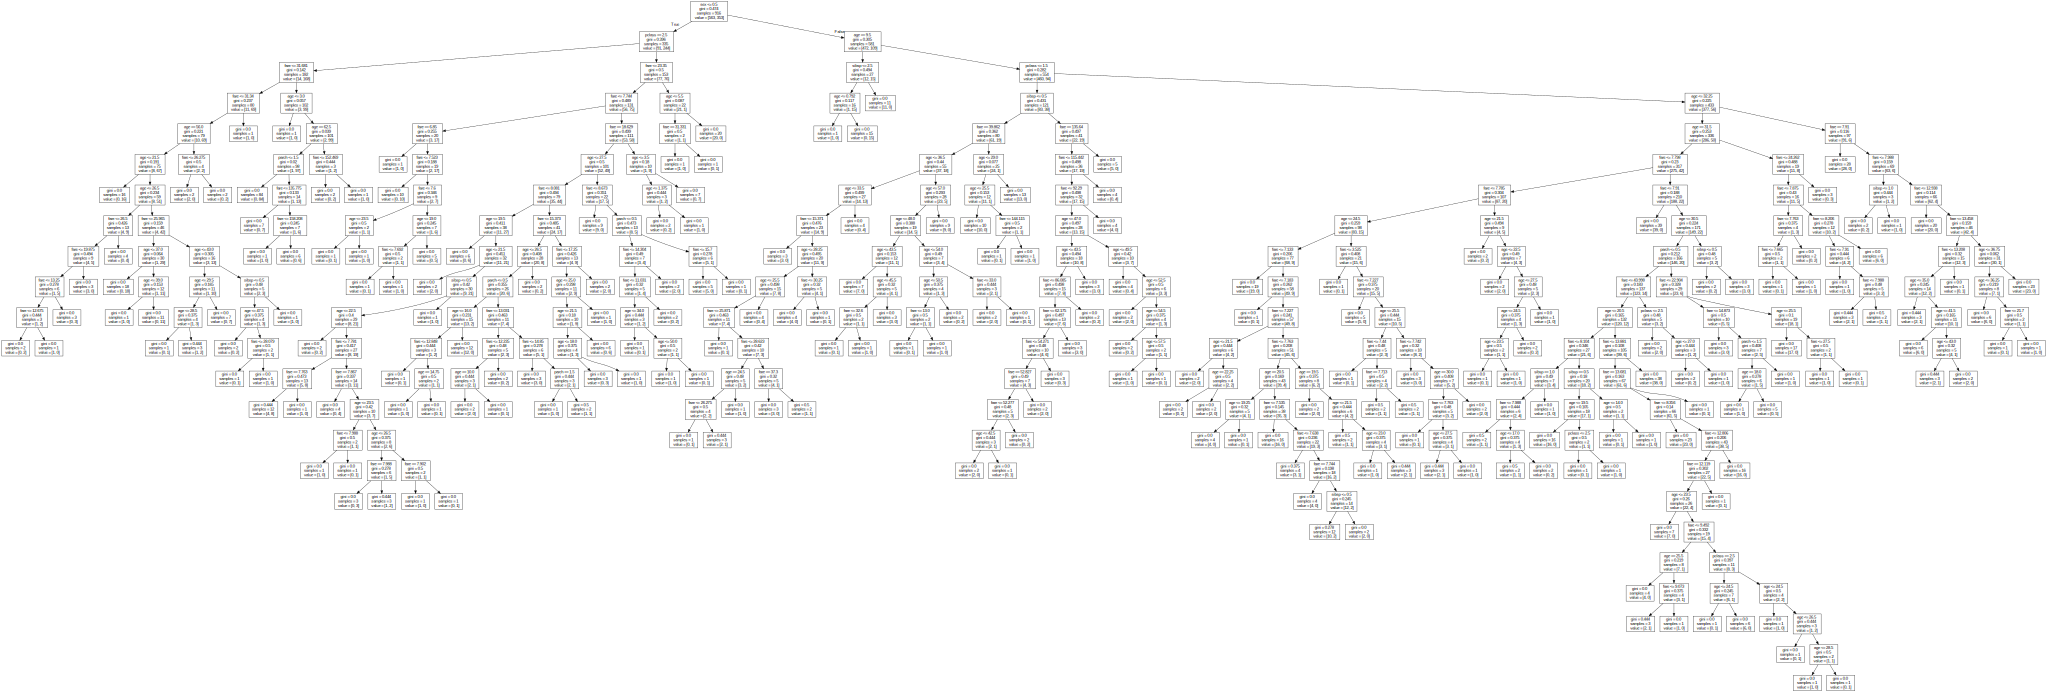

In [16]:
from sklearn.tree import export_graphviz
import graphviz # Package containing visualization tools

export_graphviz(clf, out_file="mytree.dot", feature_names=data.columns.drop('survived')) # Save the visualization of the tree
with open("mytree.dot") as f: # read the file back in
    dot_graph = f.read()
graphviz.Source(dot_graph) # display the tree

**YOUR TURN:** Explore the decision tree and answer the following:
* What feature does the root node split on? **Sex**
* What is the depth of the decision tree (i.e., the length of the longest path from root to leaf)? **15**
* Do you think this decision tree is prone to overfitting? Why/why not? **Yes, the depth is incredibly large and is fitting to noise.**

To reduce the degree to which this tree is overfit to the training data, we can force the tree to be of some *maximum depth*. This ensures the tree won't be able to just keep generating new layers to properly classify every sample in the training stage (and, thus, presumably generalize better to the test set).

Let's try limiting the max depth to 2 and visualizing the resulting tree.

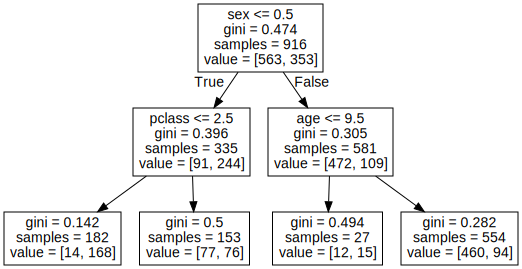

In [17]:
clf = tree.DecisionTreeClassifier(max_depth = 2)

clf.fit(X_train, y_train)

export_graphviz(clf, out_file="mytree.dot", feature_names=data.columns.drop('survived'))
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Much simpler! As we can see, our model finds Age, Sex, and Pclass to be the most important features. We would expect this model to have much poorer performance when predicting on the training set (as opposed to our 97% we got above), but perhaps better performance on unseen data.

There are many hyper-parameters that can be tuned to change how the model performs. Some common parameters that are modified include:
1. Max Tree Depth: How "tall" do you want your tree to be
2. Minimum Samples Per Leaf: This parameter defines the minimum number of training datapoints that fall into a given leaf node in order for that node to be created
3. Minimum Samples to Split: This parameter controls the minimum number of samples required to create a decision split

To decide the values of each of the parameters, we can use Grid Search combined with cross validation. In Grid Search, we first decide what potential values we want each hyperparameter will take. Then we find every possible combination of parameters and run cross validation on each combination to estimate the performance of that hyperparameter combination.

Luckily, `sklearn` has a nice implementation of Grid Search that runs this algorithm for us. Lets see a demo below:

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

clf = tree.DecisionTreeClassifier() # First we define our model without passing in parameters
hyperparameter_search = { # Then we decide the possible parameter combinations
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 5, 8, 11],
    'min_samples_leaf': [2, 5, 8, 11]
} # Since we have 3 parameters with 2 possible values, grid search will test 3^3 combinations
evaluation_metric = make_scorer(accuracy_score, # GridSearchCV requires us to wrap our metric function in a "scorer"
                                greater_is_better = True)

grid_search_cv = GridSearchCV(estimator = clf,
                              param_grid = hyperparameter_search,
                              scoring = evaluation_metric,
                              cv = 5) # Set up search algorithm
grid_search_cv.fit(X_train, y_train) # Run the search. NOTE: This may take a while

print("Best Parameters: ", grid_search_cv.best_params_) # Print the parameters
print ("Best CV Accuracy: ", grid_search_cv.best_score_ * 100, "%")

clf = grid_search_cv.best_estimator_ # Get the best model from the GridSearch
accuracy = accuracy_score(y_test, clf.predict(imp.transform(X_test)))
print ("Testing Accuracy: ", accuracy * 100, "%") # Print the testing accuracy of the best model

Best Parameters:  {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best CV Accuracy:  81.54906153480637 %
Testing Accuracy:  81.1704834605598 %


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In the cell above, we tested our two values per hyperparameter and ran grid search to find the best combination from the space we defined. As you may have noticed, the number of combinations tested by Grid Search exponentially increases as you test more values and tune more hyperparameters. This means that performing a grid search is often a task that takes a long period of time and is often note used for more complex models like neural networks.

### Random Forests, Gradient Boosting, Extreme Gradient Boosting

Let's (briefly) investigate some more advanced tree models that you have learned about and see if we can improve our performance. We will be using the following models in addition to our decision tree classifier:

* Scikitlearn Random Forest classifier
* Scikitlearn Gradient boosting classifier
* XGBoost classifier

Note that XGBoost is similar in theory to Scikitlearn's Gradient boosting classifier. However, XGBoost's implementation is highly efficient than that of Scikitlearn's. Forests are *ensemble* techniques that combine multiple decision trees. As you learned in lecture, and as visualized below, random forest methods usually combine multiple trees through some sort of voting scheme.

<img src="https://github.com/lyeskhalil/mlbootcamp/blob/master/img/random-forest.png?raw=1" width="400"/>

In the above example, two trees vote (predict) Class B and another predicts Class A, so the overall ensemble vote goes to the majority (Class B). Boosting, on the other hand, uses multiple trees in in a stage-wise fashion. Popular machine learning software XGBoost has a great explanation for [how this works](https://xgboost.readthedocs.io/en/latest/tutorials/model.html).

Let's build some ensemble classifiers!

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

Now, let's see how they perform!

In [20]:
clf = tree.DecisionTreeClassifier()
clf_random = RandomForestClassifier()
clf_gradient = GradientBoostingClassifier()
clf_xgb = XGBClassifier()

scores = cross_val_score(clf, X_train, y_train, cv=5)
scores_random = cross_val_score(clf_random, X_train, y_train, cv=5)
scores_gradient = cross_val_score(clf_gradient, X_train, y_train, cv=5)
scores_xgb = cross_val_score(clf_xgb, X_train, y_train, cv=5)

print("Decision tree accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Random forest accuracy: %0.2f (+/- %0.2f)" % (scores_random.mean(), scores_random.std() * 2))
print("Gradient boosting accuracy: %0.2f (+/- %0.2f)" % (scores_gradient.mean(), scores_gradient.std() * 2))
print("XGBoost accuracy: %0.2f (+/- %0.2f)" % (scores_xgb.mean(), scores_xgb.std() * 2))

Decision tree accuracy: 0.77 (+/- 0.05)
Random forest accuracy: 0.80 (+/- 0.04)
Gradient boosting accuracy: 0.80 (+/- 0.05)
XGBoost accuracy: 0.80 (+/- 0.07)


We can see that each of the more sophisticated tree/forest methods improves upon the initial decision tree accuracy in terms of cross-validated accuracy, with Extreme Gradient boosting providing the best result.

Let's see how the extreme gradient boosted method performs on the hold-out test set.

In [21]:
from sklearn.metrics import accuracy_score

clf_xgb.fit(X_train, y_train)
accuracy = accuracy_score(y_test, clf_xgb.predict(X_test))

print ("Test set accuracy: ", accuracy * 100, "%")

Test set accuracy:  79.38931297709924 %


First, we imputed the missing values in the test set (as we had done for the training set) and then we applied our gradient boosting-based classifier (as trained on the training data). We yielded an ~81% accuracy; not bad!

**YOUR TURN:**
* What features did the gradient boosting algorithm find the most important? __________________ (Hint: You can use the same code to get the importances like we did for the random forest above)
* What is the test set accuracy if, instead, you used the Scikitlearn's gradient boosting algorithm? __________________

* If you designed a naive classifier that simply guessed 'did not survive' (i.e., Survived = 0) for every row in the test set, how would it perform? ________________________
* Is this better or worse than our gradient boosted tree? ____________________________



In [25]:
print("Feature Importances =-=-=-=-=-")
for feature, importance in zip(data.columns, clf_gradient.feature_importances_):
    print(feature, importance)
print("=-=-=-=-=")
clf_gradient.fit(X_train, y_train)
accuracy = accuracy_score(y_test, clf_gradient.predict(X_test))

print ("Test set accuracy: ", accuracy * 100, "%")
print(accuracy_score(y_test, [0] * len(y_test)))


Feature Importances =-=-=-=-=-
pclass 0.15091466997844355
survived 0.4847414599950328
sex 0.09824237389101044
age 0.05076686590556636
sibsp 0.008434518348830427
parch 0.20690011188111637
=-=-=-=-=
Test set accuracy:  80.91603053435115 %
0.6259541984732825


##### Congratulatons!

You're finished this lab. On to the next!